# Probabilistic ML: Assignment 2
- **Deadline**: Feb 16, 23:59 ET
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.



# Question 2: Markov chain Monte Carlo in the TrueSkill model

The goal of this question is to get you familiar with the basics of
Bayesian inference in medium-sized models with continuous latent variables, and the basics of Langevin and Hamiltonian Monte Carlo.

## Background

We'll implement a variant of the [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess.

This assignment is based on [this one](https://mlg.eng.cam.ac.uk/teaching/4f13/2324/) developed by Carl Rasmussen at Cambridge for his course on probabilistic machine learning.

## Model definition
We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch.distributions.normal import Normal

from functools import partial

import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=bbc999a5fb43ba532fd216fdc2cbd962f921a65a6223e1a7d275b05a90c7ec59
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


## Q 2.1 Implementing the TrueSkill Model [10 points]

###	Q 2.1.a [4 points]
Implement a function $\texttt{log_joint_prior}$ that computes the log of the prior, jointly evaluated over all player's skills.

  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.

In [2]:
def log_joint_prior(zs_array):
  # TODO
  # Assume Normal(0,1)
  distri = Normal(0., 1.)
  return distri.log_prob(zs_array).sum(axis=-1, keepdims=True)

### Q 2.1.b [6 points]

Implement two functions $\texttt{logp_a_beats_b}$ and $\texttt{logp_b_beats_a}$.

Given a pair of skills $z_a$ and $z_b$, $\texttt{logp_a_beats_b}$ evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above, and $\texttt{logp_b_beats_a}$ is vice versa.

To ensure numerical stability, use the function $torch.logaddexp$


In [3]:
def logp_a_beats_b(z_a, z_b):
  # Hint: Use torch.logaddexp
  # TODO
  return -torch.logaddexp(torch.zeros(1), -(z_a - z_b))

def logp_b_beats_a(z_a, z_b):
  # Hint: Use torch.logaddexp
  # TODO
  return -torch.logaddexp(torch.zeros(1), -(z_b - z_a))

## Q 2.2 Examining the posterior for only two players and toy data [10 points]
To get a feel for this model, we'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games.

Provided in the starter code is a function $\texttt{plot_isocontours}$ which evaluates a provided function on a grid of $z_A$ and $z_B$'s and plots the isocontours of that function.
There is also a function $\texttt{plot_2d_fun}$.
We have included an example for how you can use these functions.



In [4]:
# Plotting helper functions
def plot_isocontours(ax, func, steps=100):
    x = torch.linspace(-4, 4, steps=steps)
    y = torch.linspace(-4, 4, steps=steps)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    Z = func(X, Y)
    cs = plt.contour(X, Y, Z )
    plt.clabel(cs, inline=1, fontsize=10)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()


### Q 2.2.a [2 point]
For two players $A$ and $B$, plot the isocontours of the joint prior over their skills.  Also plot the line of equal skill, $z_A = z_B$. Use the helper function `plot_2d_fun` above to plot.

According to the prior, what's the chance that player A is better than player B?

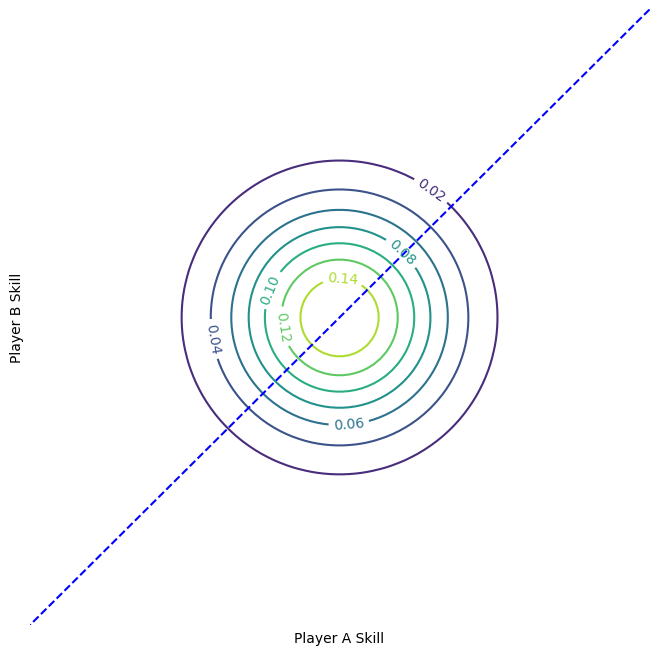

<Figure size 640x480 with 0 Axes>

In [5]:
def log_prior_over_2_players(z1, z2):
  # TODO
  # Assume Normal(0,1)
  distri = Normal(0., 1.)
  return distri.log_prob(z1) + distri.log_prob(z2)

def prior_over_2_players(z1, z2):
  return torch.exp(log_prior_over_2_players(z1, z2))

plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill")

Based on the graph above, we can see the line of equal skill splits the contour by half. So, the chance that player A is better than player B is 50%.

### Q 2.2.b [3 points]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that player A
beat player B in one match.  Since the contours don't depend on the normalization
constant, you can simply plot the isocontours of the log of joint distribution of
$p(z_A, z_B | \text{A beat B})$. Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, which player is likely to have higher skill?

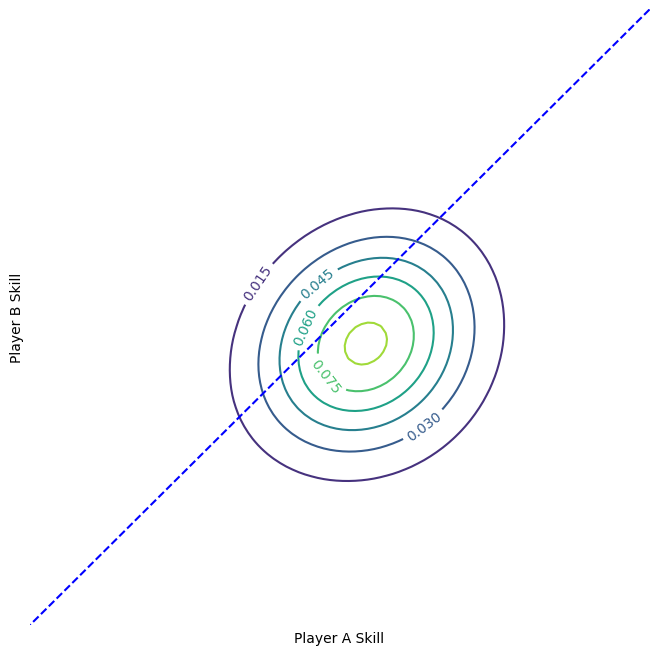

<Figure size 640x480 with 0 Axes>

In [6]:
def log_posterior_A_beat_B(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use the log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2) # Unnormalized

def posterior_A_beat_B(z1, z2):
  return torch.exp(log_posterior_A_beat_B(z1, z2))

plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")
# Note that the posterior probabilities shown are unnormalized

Based on the plot above, we can see the area of contour below the line of equal skill is larger than the area above the line. Then, we can infer that player A is likely to have a higher skill.

### Q 2.2.c [2 point]

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
5 matches were played, and player A beat player B in all matches.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it plausible that player B is more skilled than player A?

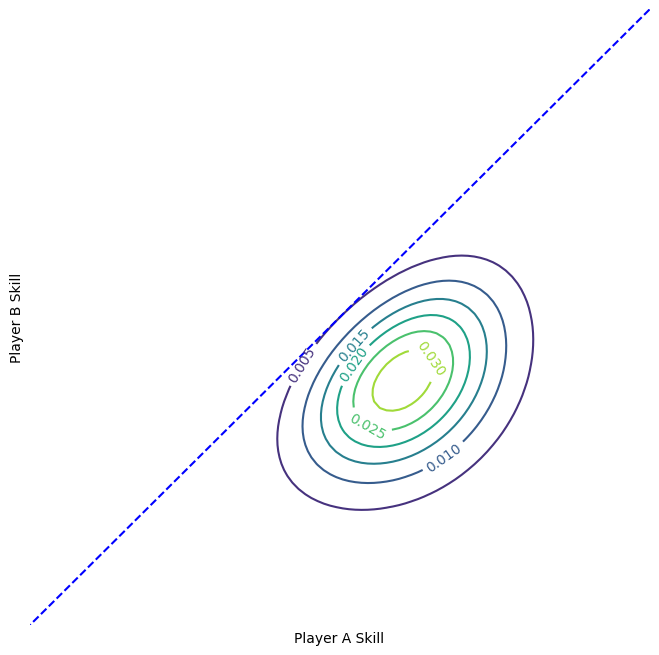

<Figure size 640x480 with 0 Axes>

In [7]:
def log_posterior_A_beat_B_5_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function.
  return log_prior_over_2_players(z1, z2) + 5 * logp_a_beats_b(z1, z2) # Unnormalized

def posterior_A_beat_B_5_times(z1, z2):
  return torch.exp(log_posterior_A_beat_B_5_times(z1, z2))

plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill")

Based on the plot above, we can see that all the contour is below than the line of equal skill. So, we can infer that it is not plausible that Player B is more skilled than Player A.

### Q 2.2.d [3 point]

Plot isocontours of the joint posterior over $z_A$ and $z_B$ given that
10 matches were played, and each player beat the other 5 times.
Also plot the line of equal skill, $z_A = z_B$.

To think about: According to this posterior, is it likely that one player is much better than another?  Is it plausible that both players are better than average?  Worse than average?

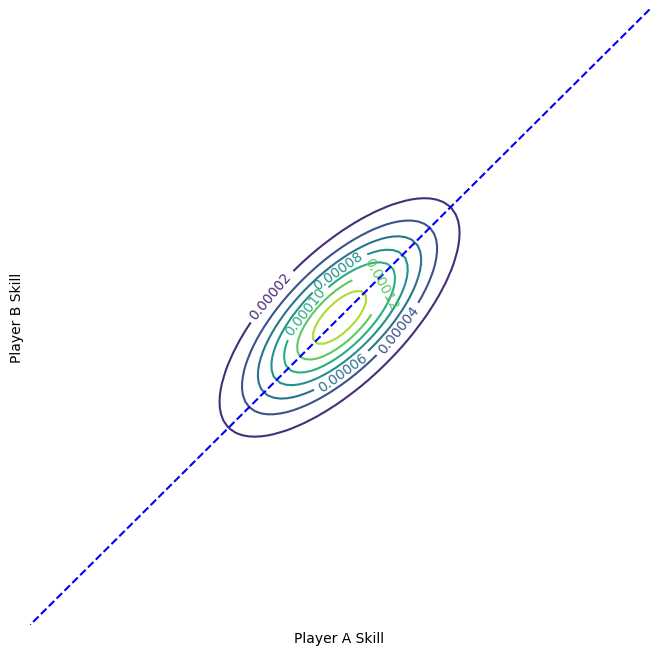

<Figure size 640x480 with 0 Axes>

In [8]:
def log_posterior_beat_each_other_5_times(z1, z2):
  # TODO: Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) \
    + 5 * logp_a_beats_b(z1, z2) \
    + 5 * logp_b_beats_a(z1, z2) # Unnormalized

def posterior_beat_each_other_5_times(z1, z2):
  return torch.exp(log_posterior_beat_each_other_5_times(z1, z2))

plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill")

From the plot above, we can see that the line of equal skill split the contour by half. Then, we can infer that the skill between A and B is around the same. So, it's not likely that one player is much better than the other. We cannot determine if both players are better than average or worse than average, which is uncertain.

## Q 2.3 Hamiltonian and Langevin Monte Carlo on Two Players and Toy Data [8 points]

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.
Carl Rasmussen's assignment uses Gibbs sampling.

In this question, we will approximate posterior distributions with gradient-based Hamiltonian and Langevin Monte Carlo.

In the next assignment, we'll use gradient-based stochastic variational inference, which wasn't invented until around 2014.


In [9]:
random.seed(42)
torch.manual_seed(42)

In [10]:
# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  # See https://en.wikipedia.org/wiki/Leapfrog_integration
  momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
  params_t1 =      params_t0      +       stepsize * momentum_thalf
  momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
  return params_t1, momentum_t1


def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
  for i in range(0, num_leapfrog_steps):
    theta, v = leapfrog(theta, v, stepsize, grad_fun)
  return theta, v

def metropolis_hastings(state1, state2, log_posterior):
  # Compares the log_posterior at two values of parameters,
  # and accepts the new values proportional to the ratio of the posterior
  # probabilities.
  accept_prob = torch.exp(log_posterior(state2) - log_posterior(state1))
  if random.random() < accept_prob:
    return state2  # Accept
  else:
    return state1  # Reject

def draw_samples_hmc(num_params, stepsize, num_leapfrog_steps, n_samples, log_posterior):
  theta = torch.zeros(num_params)

  def log_joint_density_over_params_and_momentum(state):
    params, momentum = state
    m = Normal(0., 1.)
    return m.log_prob(momentum).sum(axis=-1) + log_posterior(params)

  def grad_fun(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad



  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(theta)

    momentum = torch.normal(0, 1, size = np.shape(theta))

    theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)

    theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), log_joint_density_over_params_and_momentum)
  return torch.stack((sampleslist))


Using samples generated by HMC, we can approximate the joint posterior where we observe player A winning 1 game.

100%|██████████| 2500/2500 [01:39<00:00, 25.06it/s]


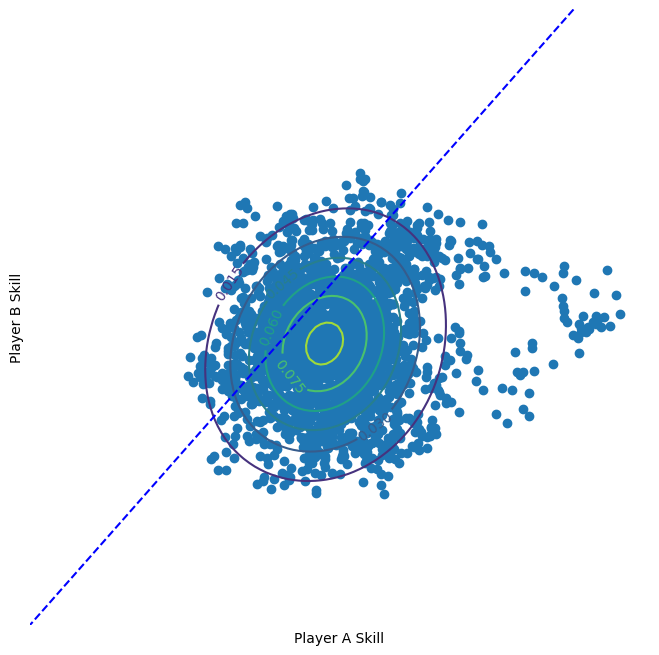

<Figure size 640x480 with 0 Axes>

In [11]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01

def log_posterior_a(zs):
  z1, z2 = zs[0], zs[1]
  return log_posterior_A_beat_B(z1, z2)

samples_a = draw_samples_hmc(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

### Q 2.3.a [2 point]

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 5 games against player B.  Hint:  You can re-use the code from when you plotted the isocontours.

100%|██████████| 2500/2500 [01:20<00:00, 31.03it/s]


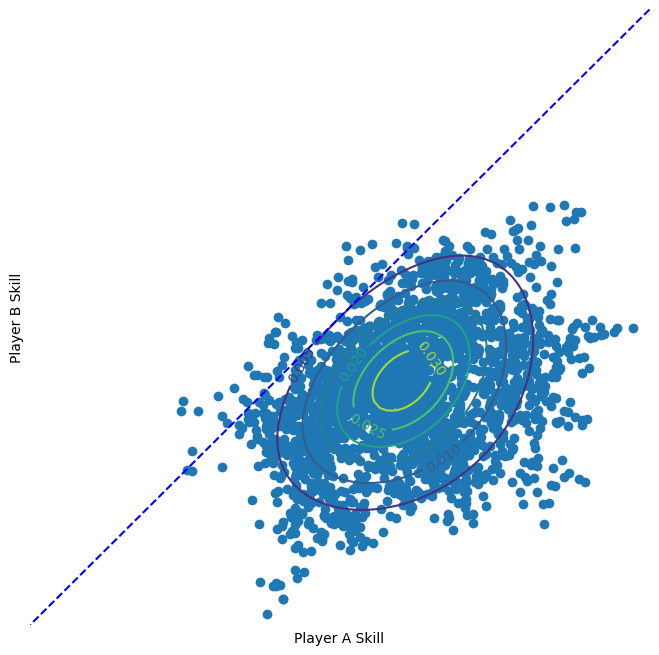

<Figure size 640x480 with 0 Axes>

In [12]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01


def log_posterior_b(zs):
  # TODO
  z1, z2 = zs[0], zs[1]
  return log_posterior_A_beat_B_5_times(z1, z2)


# TODO Run HMC and plot the posterior contour and the samples
samples_b = draw_samples_hmc(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_b)
plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill", samples_b)

### Q 2.3.b [2 point]

Using samples generated by HMC, approximate the joint posterior where we observe player A winning 5 games and player B winning 5 games.

100%|██████████| 2500/2500 [01:31<00:00, 27.39it/s]


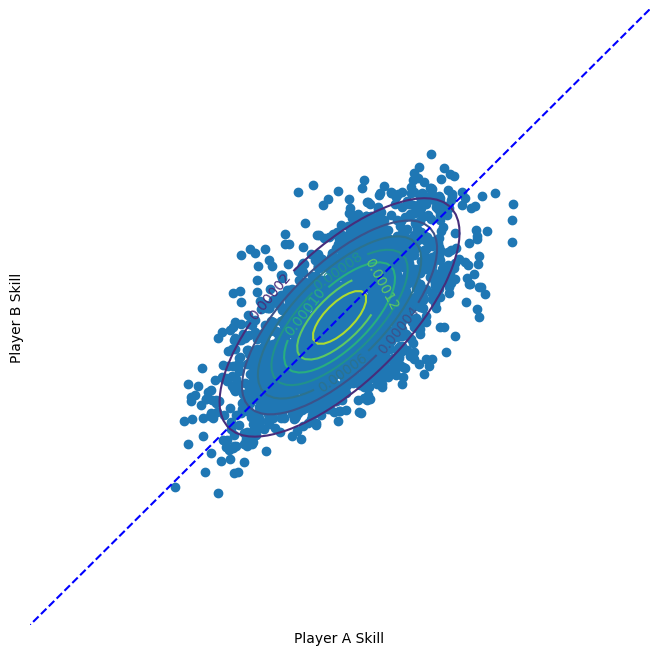

<Figure size 640x480 with 0 Axes>

In [13]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01

def log_posterior_c(zs):
  # TODO
  z1, z2 = zs[0], zs[1]
  return log_posterior_beat_each_other_5_times(z1, z2)

# TODO Run HMC and plot the posterior contour and the samples
samples_c = draw_samples_hmc(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_c)
plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill", samples_c)

### Q 2.3.c [2 points]

We now implement the simpler Langevin Monte Carlo algorithm with the Metropolis-Hastings filter. Recall that to sample from a posterior distribution $p(z|D)$ with LMC, starting from some intialization $z_0$, we iteratively compute the proposal
$$z'_{t+1} = z_t + \eta \nabla \log p(z|D) + \sqrt{2 * \eta}W,$$
where $W \sim N(0,I)$. Then, we accept $z'_{t+1}$ according to the Metrapolis-Hastings Algorithm, i.e. we define
$$A = \frac{p(z'_{t+1}|D)\exp\big(-\Vert z_t - z'_{t+1} - \eta * \nabla \log p(z'_{t+1}|D)\Vert^2\big)}{p(z_t|D)\exp\big(-\Vert z'_{t+1} - z_t - \eta * \nabla \log p(z_t|D)\Vert^2\big)}.$$
We then generate $u \sim \mathrm{Unif}(0,1)$, and accept the proposal iff $u \leq A$, in other words
$$z_{t+1} = \begin{cases}z'_{t+1} & \text{if}\, u \leq A\\
z_t & \text{if}\, u > A\end{cases}.$$

Complete the following implementation of LMC with the Metropolis-Hastings filter.

In [14]:
from logging import log
def draw_samples_lmc(num_params, stepsize, n_samples, log_posterior):
  zs = torch.zeros(num_params)

  def grad_log_posterior(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad

  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(zs)

    # TODO: Perform LMC with Metrapolis Hastings step to get new zs
    # Hint: You can reuse the metraplis_hastings method from before
    # Hint: You can use grad_log_posterior

    grad = grad_log_posterior(zs)
    zs_new = zs + stepsize * grad + torch.sqrt(torch.tensor(2.0) * stepsize) * torch.normal(mean=0, std=1, size=zs.shape)

    log_posterior_old = log_posterior(zs)
    log_posterior_new = log_posterior(zs_new)

    norm1 = torch.norm(zs - zs_new - stepsize * grad)
    norm2 = torch.norm(zs_new - zs - stepsize * grad)

    accept_prob = torch.exp(log_posterior_new - log_posterior_old) * torch.exp(-norm1**2) / torch.exp(-norm2**2)
    if random.random() <= accept_prob:
      zs = zs_new

  return torch.stack(sampleslist)

Run the provided code to generate samples via LMC for approximating the joint posterior where we observe player A winning 5 games and player B winning 5 games.

100%|██████████| 2500/2500 [00:04<00:00, 582.65it/s]


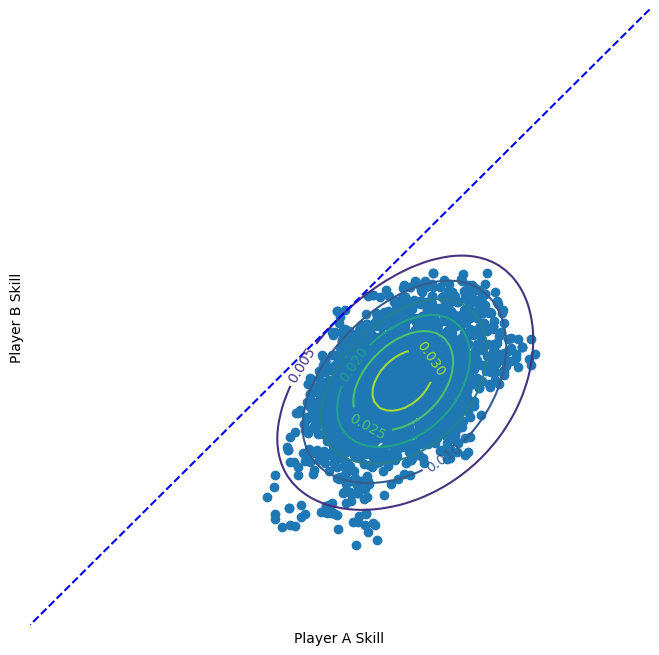

<Figure size 640x480 with 0 Axes>

In [15]:
num_players = 2
n_samples = 2500
stepsize = 0.01
key=42

samples_b_lmc = draw_samples_lmc(num_players, stepsize, n_samples, log_posterior_b)

ax = plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill", samples_b_lmc)

### Q2.3.d [2 points]
In the answer box below, provide one general advantage and one general disadvantage of LMC in comaprison with HMC.

(enter your response here):

1. Advantage: LMC has lower computational costs because in each step it only requires gradient evaluation once. However, in HMC, there are multiple leapfrog steps. Thus, LMC is computationally cheaper and faster compared with HMC, making it ideal for high-dimensional data.

2. Disadvantage: In LMC, the random variable W~N(0,1) is introduced. When the step $\eta$ is small, it is similar to a random walk process such that it has high autocorrelation between each step. On the other hand, HMC uses Hailtonian dynamics, avoiding random walk and making the update more efficient.

## Q 2.4 Approximate inference conditioned on real data [26 points]

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost. Note that what we refer to as team here is the same as a player in the previous parts; we assume each team has a skill following the TrueSkill model.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022




In [16]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   163k      0 --:--:-- --:--:-- --:--:--  163k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [17]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()

### Q 2.4.a [5 points]

Assuming all game outcomes are i.i.d. conditioned on all teams' skills, implement a function $\texttt{log_games_likelihood}$ that takes a batch of team skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihoods for all those observations given all the skills.

Hint: You should be able to write this function without using $\texttt{for}$ loops, although you might want to start that way to make sure what you've written is correct.  If $A$ is an array of integers, you can index the corresponding entries of another matrix $B$ for every entry in $A$ by writing $\texttt{B[A]}$.

In [18]:
def log_games_likelihood(zs, games):
  # games is an array of size (num_games x 2)
  # zs is an array of size (num_players)
  #
  # Hint: With broadcasting, this function can be written
  # with no for loops.
  #
  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]
  winning_player_skills = zs[winning_player_ixs]    #TODO: Look up the skill of the winning player in each game.
  losing_player_skills = zs[losing_player_ixs]      #TODO: Look up the skills of the losing player in each game.
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)          #TODO: Compute the log_likelihood of each game outcome.
  return torch.sum(log_likelihoods)                     #TODO: Combine the log_likelihood of independent events.

  
### Q 2.4.b [3 points]
Implement a function $\texttt{joint_log_density}$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [19]:
def log_joint_probability(zs, games):
  # Todo: Combine log_prior and log_likelihood
  return log_joint_prior(zs) + log_games_likelihood(zs, games)

### Q 2.4.c [5 points]
Run Langevin Monte Carlo on the posterior over all skills conditioned on all the chess games from the dataset.  Run for 10000 samples.

In [20]:
# Hyperparameters
num_players = len(names)
n_samples = 10000
stepsize = 0.01


#Hint: you will need to use games
def log_posterior(zs):
  return log_joint_probability(zs, games)

# TODO: all_games_samples = ...
all_games_samples = draw_samples_lmc(num_players, stepsize, n_samples, log_posterior)


100%|██████████| 10000/10000 [00:19<00:00, 519.35it/s]


### Q 2.4.d [3 points]
Based on your samples from the previous question, plot the approximate mean and variance of the marginal skill of each player, sorted by average skill. There's no need to include the names of the players.  Label the axes "Player Rank", and "Player Skill".

<ErrorbarContainer object of 3 artists>

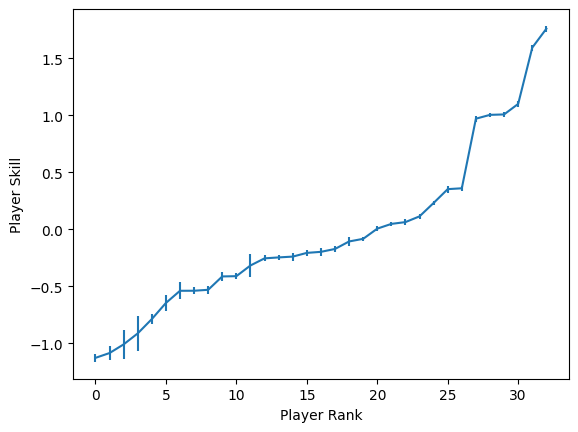

In [21]:
# TODO
mean_skills = torch.mean(all_games_samples, axis=0)
sorted_indices = torch.argsort(mean_skills, axis=0)
mean_skills = mean_skills[sorted_indices]
var_skills = torch.var(all_games_samples, axis=0)
var_skills = var_skills[sorted_indices]

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills, var_skills)

### Q 2.4.e [2 points]
List the names of the 5 teams with the lowest mean skill and 5 teams with the highest mean skill according to your samples.

In [22]:
print("Bottom 5")
# TODO: print the 5 players with the lowest mean skill
print(names[sorted_indices[:5]])

print("Top 5")
# TODO: print the 5 players with the highest mean skill
print(names[sorted_indices[-5:]])

Bottom 5
['Norwich City' 'Huddersfield' 'Middlesbrough' 'QPR' 'Sunderland']
Top 5
['Tottenham' 'Arsenal' 'Manchester Utd' 'Liverpool' 'Manchester City']


### Q 2.4.f [2 points]
Use a scatterplot to show your samples over the joint posterior over the skills of Southampton and Wolves.  Include the line of equal skill.  Hint: you can use `plt.scatter`.


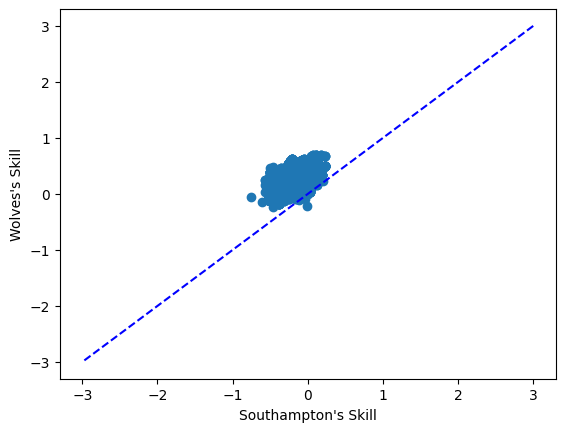

In [23]:
# TODO
Southampton_index = np.where(names == "Southampton")[0]
Wolves_index = np.where(names == "Wolves")[0]
Southampton_samples = all_games_samples[:,Southampton_index]
Wolves_samples = all_games_samples[:,Wolves_index]

plt.xlabel("Southampton's Skill")
plt.ylabel("Wolves's Skill")
plt.scatter(Southampton_samples, Wolves_samples)
plt.plot([3, -3], [3, -3], 'b--')

### Q 2.4.g [3 points]
Using your samples, find the team that bas the eleventh highest mean skill. Print an unbiased estimate of the probability that the team with the twelfth highest mean skill is not worse than Southampton, again as estimated from your samples. Hint: Probabilities of Bernoulli random variables can be written as the expectation that the Bernoulli takes value 1, so you can use simple Monte Carlo. The final formula will be very simple.

In [24]:
# TODO
team_11_index = sorted_indices[-11]
team_12_index = sorted_indices[-12]

prob_estimate = torch.mean((all_games_samples[:, team_12_index] >= all_games_samples[:, Southampton_index]).float())
print(f"Team with 11th highest mean skill: {names[team_11_index]}")
print(f"Unbiased estimate of probability: {prob_estimate.item():.4f}")



Team with 11th highest mean skill: Brighton
Unbiased estimate of probability: 0.8537


### Q 2.4.h [3 points]

For any two players $i$ and $j$, $p(z_i, z_j | \text{all games})$ is always proportional to $p(z_i, z_j , \text{all games})$, as a function of $z_i$ and $z_j$.

In general, are the isocontours of $p(z_i, z_j | \text{all games})$ the same as those of $p(z_i, z_j | \text{games between $i$ and $j$})$?  That is, do the games between other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$?  A simple yes or no suffices.

Hint: One way to answer this is to draw the graphical model for three players, $i$, $j$, and $k$, and the results of games between all three pairs, and then examine conditional independencies.  If you do this, include the graphical models in your assignment.

Your answer here:  Yes or no?

No, the isocontours of $p(z_i, z_j | \text{all games})$ are not the same as those of $p(z_i, z_j | \text{games between $i$ and $j$})$. Because even though 2 players don't directly compete with each other, their relative skills can be inferred from transient relationships in games with other players. So, the games between other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$.

